In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

https://m.blog.naver.com/PostView.nhn?blogId=sexyit_2019&logNo=221603292906&proxyReferer=https:%2F%2Fwww.google.com%2F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 오디오 데이터
DATA_DIR_TRAIN = '/content/drive/My Drive/졸프/합산2_train/'
DATA_DIR_TEST = '/content/drive/My Drive/졸프/합산2_test/'

In [ ]:
wav, sr = librosa.load(DATA_DIR_TRAIN + '음100.wav', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 8000
wav shape: (1937,)
length: 0.242125 secs


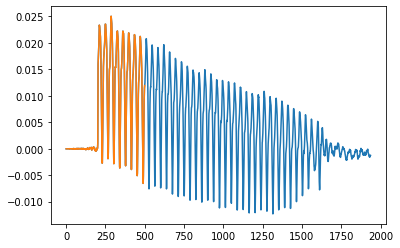

In [ ]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [ ]:
train_X = []
train_spectrograms = []
train_mel_spectograms = []
train_mfccs = []
train_y = []

test_X = []
test_spectrograms = []
test_mel_spectograms = []
test_mfccs = []
test_y = []

pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

# STFT 한 것, CNN 분석하기 위해 Spectogram으로 만든 것, MF한 것, mel0spectogram 한 것


In [ ]:
from unicodedata import normalize

In [ ]:
dataset0 = [] # 추임새
dataset1 = [] # 비추임새

test_dataset = []
train_dataset = []

In [ ]:
for filename in os.listdir(DATA_DIR_TRAIN):
  filename = normalize('NFC', filename)
  try:
    if '.wav' not in filename in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR_TRAIN + filename)
    padded_x = pad1d(wav, 30000)
    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc, 40)

    # 추임새 별로 dataset에 추가
    if filename[0] == '외':
      train_dataset.append((padded_x, padded_mfcc, 1))
    else:
      train_dataset.append((padded_x, padded_mfcc, 0))
  except Exception as e:
    print(filename, e)
    raise

for filename in os.listdir(DATA_DIR_TEST):
  filename = normalize('NFC', filename)
  try:
    if '.wav' not in filename in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR_TEST + filename)
    padded_x = pad1d(wav, 30000)
    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc, 40)

    # 추임새 별로 dataset에 추가
    if filename[0] == '외':
      test_dataset.append((padded_x, padded_mfcc, 1))
    else:
      test_dataset.append((padded_x, padded_mfcc, 0))
  except Exception as e:
    print(filename, e)
    raise

# 추임새 별 데이터셋을 셔플한 후 testset과 trainset으로 split
import random
random.shuffle(test_dataset)
random.shuffle(train_dataset)

train_X = [a for (a,b,c) in train_dataset]
train_mfccs = [b for (a,b,c) in train_dataset]
train_y = [c for (a,b,c) in train_dataset]

test_X = [a for (a,b,c) in test_dataset]
test_mfccs = [b for (a,b,c) in test_dataset]
test_y = [c for (a,b,c) in test_dataset]

train_X = np.vstack(train_X)
train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_X = np.vstack(test_X)
test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_X:', train_X.shape)
print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_X:', test_X.shape)
print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)


train_X: (787, 30000)
train_mfccs: (787, 20, 40)
train_y: (787, 2)
test_X: (305, 30000)
test_mfccs: (305, 20, 40)
test_y: (305, 2)


In [ ]:
ip = Input(shape = (train_X[0].shape))
hidden = Dense(128, activation='relu')(ip)
op = Dense(2, activation='softmax')(hidden)
model = Model(input=ip, output=op)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3840128   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 3,840,386
Trainable params: 3,840,386
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X,
                    train_y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(test_X, test_y))

Train on 787 samples, validate on 305 samples
Epoch 1/10
787/787 [==============================] - 2s 2ms/step - loss: 0.8008 - accuracy: 0.5845 - val_loss: 0.6107 - val_accuracy: 0.7049
Epoch 2/10
787/787 [==============================] - 1s 2ms/step - loss: 0.2266 - accuracy: 0.9339 - val_loss: 0.5667 - val_accuracy: 0.7180
Epoch 3/10
787/787 [==============================] - 1s 2ms/step - loss: 0.1364 - accuracy: 0.9670 - val_loss: 0.5729 - val_accuracy: 0.7344
Epoch 4/10
787/787 [==============================] - 1s 2ms/step - loss: 0.0947 - accuracy: 0.9784 - val_loss: 0.5739 - val_accuracy: 0.7475
Epoch 5/10
787/787 [==============================] - 1s 2ms/step - loss: 0.0673 - accuracy: 0.9873 - val_loss: 0.5866 - val_accuracy: 0.7639
Epoch 6/10
787/787 [==============================] - 1s 2ms/step - loss: 0.0501 - accuracy: 0.9911 - val_loss: 0.6064 - val_accuracy: 0.7738
Epoch 7/10
787/787 [==============================] - 1s 2ms/step - loss: 0.0378 - accuracy: 0.9962 - 

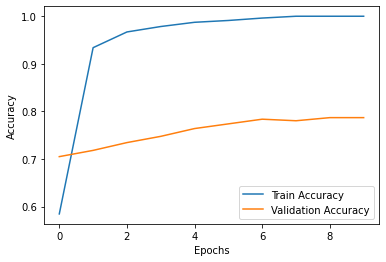

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (787, 20, 40, 1)
test X shape: (305, 20, 40, 1)


In [ ]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(64, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)
# m = Conv2D(128, kernel_size=(2,2), activation='relu')(ip)
# m = MaxPooling2D(pool_size=(2,2))(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(2, activation='softmax')(m)

model = Model(input=ip, output=op)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 20, 40, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 37, 64)        1088      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 9, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                73760     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 74,914
Trainable params: 74,914
Non-trainable params: 0
_______________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Train on 787 samples, validate on 305 samples
Epoch 1/100
787/787 [==============================] - 1s 863us/step - loss: 1.4260 - accuracy: 0.8488 - val_loss: 0.4509 - val_accuracy: 0.8361
Epoch 2/100
787/787 [==============================] - 1s 664us/step - loss: 0.2349 - accuracy: 0.9123 - val_loss: 0.4335 - val_accuracy: 0.8557
Epoch 3/100
787/787 [==============================] - 1s 657us/step - loss: 0.0967 - accuracy: 0.9581 - val_loss: 0.4348 - val_accuracy: 0.8361
Epoch 4/100
787/787 [==============================] - 1s 647us/step - loss: 0.0663 - accuracy: 0.9682 - val_loss: 0.4420 - val_accuracy: 0.8393
Epoch 5/100
787/787 [==============================] - 1s 676us/step - loss: 0.0454 - accuracy: 0.9835 - val_loss: 0.5792 - val_accuracy: 0.8590
Epoch 6/100
787/787 [==============================] - 1s 723us/step - loss: 0.0396 - accuracy: 0.9860 - val_loss: 0.4632 - val_accuracy: 0.8492
Epoch 7/100
787/787 [==============================] - 1s 649us/step - loss: 0.0282 

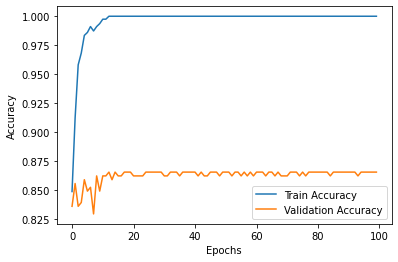

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# 샘플 오디오 데이터
DATA_DIR = '/content/drive/My Drive/졸프/'

wav, sr = librosa.load(DATA_DIR + 'sample.m4a', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 44100
wav shape: (1651712,)
length: 37.45378684807256 secs


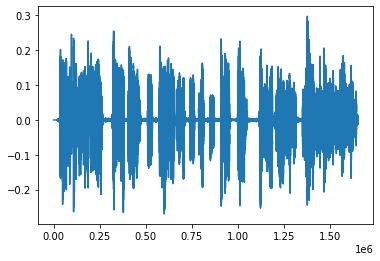

In [ ]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [ ]:
wav, sr = librosa.load(DATA_DIR + 'sample.m4a')
padded_x = pad1d(wav, 30000)
mfcc = librosa.feature.mfcc(wav)
padded_mfcc = pad2d(mfcc, 40)
padded_mfcc = np.expand_dims(padded_mfcc, -1)

In [ ]:
model.predict(padded_mfcc)

ValueError: ignored